In [148]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from plotnine import ggplot, aes, geom_line,geom_point, geom_abline,geom_text

import plotly.express as px
import matplotlib as plt
import seaborn as sns
from collections import defaultdict

plt.style.use('ggplot')

pd.set_option("display.max_columns", None)

Q1: Income and Test Results

Process includes reading all the files and exploring the way to merge the datasets

In [98]:
country_scores = pd.read_excel('https://www.cgdev.org/sites/default/files/patel-sandefur-human-capital-final-results.xlsx', sheet_name="Country Scores")
country_scores.head(5)

,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,U.A.E.,ARE,64.000000,63.982311,437.000000,440.000000
1,Argentina,ARG,51.000000,66.000000,406.652557,431.443542
2,Armenia,ARM,71.505402,NaN,454.000000,NaN
3,Australia,AUS,90.000000,92.932800,520.000000,534.000000
4,Austria,AUT,95.302193,97.104111,511.000000,533.000000


In [99]:
baci = pd.read_csv('./Project 2/rosetta/BACI_HS17_Y2018_V202001.csv', sep=',')
baci.head(5)

,t,i,j,k,v,q
0,2018,4,24,845420,101.397000,26.000
1,2018,4,24,848180,2.328000,0.007
2,2018,4,31,570110,1.596000,0.037
3,2018,4,32,340319,8.699331,0.113
4,2018,4,32,610910,1.098000,0.013


In [100]:
census = pd.read_csv('./Project 2/rosetta/usa_00001.csv', sep=',')
census.head(5)

,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
0,2000,200004,1,600.0,2000000000014,17,1,1,618.0,8,81,1,10,3130,797
1,2000,200004,1,600.0,2000000000014,17,1,2,684.0,8,81,1,10,7210,467
2,2000,200004,2,600.0,2000000000024,48,1,1,618.0,6,62,1,10,8030,359
3,2000,200004,2,600.0,2000000000024,48,1,2,609.0,6,62,3,30,5240,617
4,2000,200004,2,600.0,2000000000024,48,1,3,621.0,6,62,1,10,9360,877


In [101]:
countryCodes = pd.read_csv('./Project 2/rosetta/country_codes.csv', sep=',',encoding = "ISO-8859-1")
countryCodes.head(5)

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND


This is Q1

In [102]:
wdiData = pd.read_csv('./Project 2/rosetta/WDI_data.csv', sep=',')
wdiData.head(5)

,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,1809.01648820483
1,Afghanistan,AFG,"School enrollment, primary (% net)",SE.PRM.NENR,..
2,Afghanistan,AFG,"School enrollment, primary (% gross)",SE.PRM.ENRR,107.225357055664
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,10971.2925173789
4,Albania,ALB,"School enrollment, primary (% net)",SE.PRM.NENR,95.1996002197266


In [103]:
isNan = wdiData.isnull()
rowNan = isNan.any(axis=1)
print(wdiData[rowNan])

                                         Country Name Country Code  \
792                                               NaN          NaN   
793                                               NaN          NaN   
794                                               NaN          NaN   
795  Data from database: World Development Indicators          NaN   
796                          Last Updated: 05/21/2018          NaN   

    Series Name Series Code 2015 [YR2015]  
792         NaN         NaN           NaN  
793         NaN         NaN           NaN  
794         NaN         NaN           NaN  
795         NaN         NaN           NaN  
796         NaN         NaN           NaN  


Make sure you have no NaNs. So we remove these rows, as the offer us no information

In [104]:
cleanWDI = wdiData.copy()
cleanWDI = cleanWDI.dropna()
isNan = cleanWDI.isnull()
rowNan = isNan.any(axis=1)
print(cleanWDI[rowNan])

Empty DataFrame
Columns: [Country Name, Country Code, Series Name, Series Code, 2015 [YR2015]]
Index: []


In [105]:
isNan = countryCodes.isnull()
rowNan = isNan.any(axis=1)
print(countryCodes[rowNan])

     country_code country_name_abbreviation  \
123           490           Other Asia, nes   
181           697          Europe EFTA, nes   

                        country_name_full iso_2digit_alpha iso_3digit_alpha  
123   Other Asia, not elsewhere specified              NaN              NaN  
181  Europe EFTA, not elsewhere specified              NaN              NaN  


Explore Differnet series names. and values<br>
Looks like we're getting some weird input here '..'. So we must exchange it for a value we can use but doesn't affect our transformation <br>
Transform to "1" so its log will be 0 it

In [106]:
cleanWDI['2015Inc'] = pd.to_numeric(cleanWDI['2015 [YR2015]'], errors='coerce').fillna(1)
cleanWDI.head(5)

,Country Name,Country Code,Series Name,Series Code,2015 [YR2015],2015Inc
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,1809.01648820483,1809.016488
1,Afghanistan,AFG,"School enrollment, primary (% net)",SE.PRM.NENR,..,1.000000
2,Afghanistan,AFG,"School enrollment, primary (% gross)",SE.PRM.ENRR,107.225357055664,107.225357
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,10971.2925173789,10971.292517
4,Albania,ALB,"School enrollment, primary (% net)",SE.PRM.NENR,95.1996002197266,95.199600


In [107]:
cleanWDI = cleanWDI[cleanWDI["Series Code"].str.contains('NY.GDP.PCAP.PP.KD')]

Now we can Merge

In [108]:
countriesAndIncome = pd.merge(country_scores, cleanWDI[['Country Code', '2015Inc']], on='Country Code', how='inner')
print(countriesAndIncome.shape)
countriesAndIncome.sample(5)

(78, 7)


,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)",2015Inc
62,Senegal,SEN,56.0,46.000000,426.151825,406.763458,2293.853539
9,Bulgaria,BGR,NaN,93.048439,NaN,541.000000,17000.167247
73,Turkey,TUR,77.0,NaN,477.000000,NaN,23388.481302
7,Benin,BEN,35.0,35.000000,390.949188,394.196686,1987.167146
34,Indonesia,IDN,NaN,66.227104,NaN,432.000000,10367.695298


Now we can create the Income log and plot

In [109]:
countriesAndIncome["Log2015Inc"] = np.log(countriesAndIncome["2015Inc"])
countriesAndIncome = countriesAndIncome.sort_values(by="Country Code")
countriesAndIncome.sample(5)

,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)",2015Inc,Log2015Inc
29,Guatemala,GTM,30.000000,54.000000,348.978973,418.676117,7292.719104,8.894632
4,Austria,AUT,95.302193,97.104111,511.000000,533.000000,44353.875214,10.699955
18,Colombia,COL,49.000000,75.000000,389.937195,449.000000,12985.383135,9.471580
9,Bulgaria,BGR,NaN,93.048439,NaN,541.000000,17000.167247,9.740978
28,Georgia,GEO,72.000000,86.485489,456.000000,494.000000,9025.133143,9.107769


In [110]:
countriesAndIncome.rename(columns = {'Median Math Score (TIMSS Scale, 4th Grade)': 'TIMMS_median', 'Median Reading Score (PIRLS Scale, 4th Grade)': "PIRLS_median", "Percent Above Math Benchmark (400 on TIMSS Scale)": "TIMSS_prc", "Percent Above Reading Benchmark (400 on PIRLS Scale)": "PIRLS_prc"}, inplace=True)

<AxesSubplot:title={'center':'TIMMS median per Log GDP per Capita'}, xlabel='Log2015Inc', ylabel='TIMMS_median'>

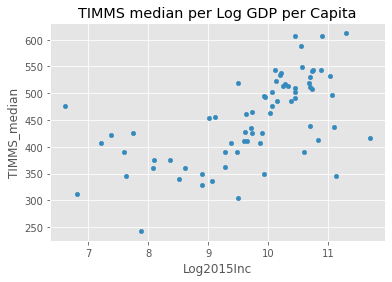

In [111]:
countriesAndIncome.plot.scatter(x="Log2015Inc", y="TIMMS_median", title="TIMMS median per Log GDP per Capita")

<AxesSubplot:title={'center':'PIRLS median per Log GDP per Capita'}, xlabel='Log2015Inc', ylabel='PIRLS_median'>

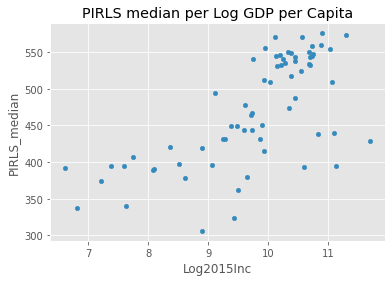

In [112]:
countriesAndIncome.plot.scatter(x="Log2015Inc", y="PIRLS_median", title="PIRLS median per Log GDP per Capita")

We can see that the TIMS score is higher in high-income countries, but it's not a linear relation, since low-income countries are also getting higher scores. <br>
PIRLS value is getting a similar trend, with higher income countries to get a better score overall<br>
Let's explore a bit better these datasets

In [113]:
countInc = countriesAndIncome.copy()
countInc = countInc.dropna()
print(countInc.shape)
countInc.head(5)

(59, 8)


,Country,Country Code,TIMSS_prc,PIRLS_prc,TIMMS_median,PIRLS_median,2015Inc,Log2015Inc
0,U.A.E.,ARE,64.000000,63.982311,437.000000,440.000000,65975.375547,11.097037
1,Argentina,ARG,51.000000,66.000000,406.652557,431.443542,19101.297392,9.857512
3,Australia,AUS,90.000000,92.932800,520.000000,534.000000,43719.502165,10.685550
4,Austria,AUT,95.302193,97.104111,511.000000,533.000000,44353.875214,10.699955
5,Azerbaijan,AZE,72.284508,81.859566,465.000000,467.000000,16698.863653,9.723096


In [114]:
corr = countInc[["Log2015Inc", "TIMMS_median", "PIRLS_median"]].corr()
corr.style.background_gradient(cmap='coolwarm')


,Log2015Inc,TIMMS_median,PIRLS_median
Log2015Inc,1.000000,0.627704,0.730905
TIMMS_median,0.627704,1.000000,0.926286
PIRLS_median,0.730905,0.926286,1.000000


In [115]:
pearCorr = countInc[["Log2015Inc", "TIMMS_median", "PIRLS_median"]].corr(method="pearson")
pearCorr.style.background_gradient(cmap='coolwarm')

,Log2015Inc,TIMMS_median,PIRLS_median
Log2015Inc,1.000000,0.627704,0.730905
TIMMS_median,0.627704,1.000000,0.926286
PIRLS_median,0.730905,0.926286,1.000000


In [116]:
spearCorr = countInc[["Log2015Inc", "TIMMS_median", "PIRLS_median"]].corr(method="spearman")
spearCorr.style.background_gradient(cmap='coolwarm')

,Log2015Inc,TIMMS_median,PIRLS_median
Log2015Inc,1.000000,0.709871,0.732082
TIMMS_median,0.709871,1.000000,0.924215
PIRLS_median,0.732082,0.924215,1.000000


Corrplot shows that there is not great correlation. But that can be explained due to the fact that <br>
lower income countries tend to also do well in TIMSS, or better yet, just as well as richer countries.
<br> <br> 
we can do pearson's (will only work for linear relationship) and spearman (we'll see if it's monotonic)

In [255]:

timmsModel = smf.ols('TIMMS_median ~ Log2015Inc', data=countInc).fit()
pirlsModel = smf.ols('PIRLS_median ~ Log2015Inc', data=countInc).fit()
print(timmsModel.summary())

                            OLS Regression Results                            
Dep. Variable:           TIMMS_median   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     37.06
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           1.03e-07
Time:                        18:39:20   Log-Likelihood:                -324.04
No. Observations:                  59   AIC:                             652.1
Df Residuals:                      57   BIC:                             656.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.5369     64.243      0.989      0.3

In [256]:
print(pirlsModel.summary())

                            OLS Regression Results                            
Dep. Variable:           PIRLS_median   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     65.38
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           4.96e-11
Time:                        18:39:28   Log-Likelihood:                -313.90
No. Observations:                  59   AIC:                             631.8
Df Residuals:                      57   BIC:                             635.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.7021     54.092      0.697      0.4

Our Models are, as expected, not great at explaining the TIMMS and PIRLS scores based on the the country income. We can see a not high enough R^2. <br>
Also from our models we get an increase of the intercept (TIMMS/PIRLS scores) of 40 and 44.8 per 1 increase of the log of a country's income

If we want to plot and visualise the regression line

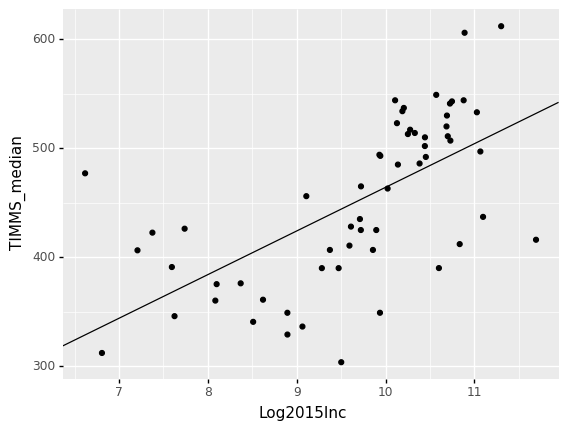

<ggplot: (8790363659981)>

In [120]:
ggplot(data=countInc)+\
    geom_point(mapping=aes(x='Log2015Inc', y='TIMMS_median'))+\
    geom_abline(intercept=timmsModel.params["Intercept"], slope=timmsModel.params["Log2015Inc"])

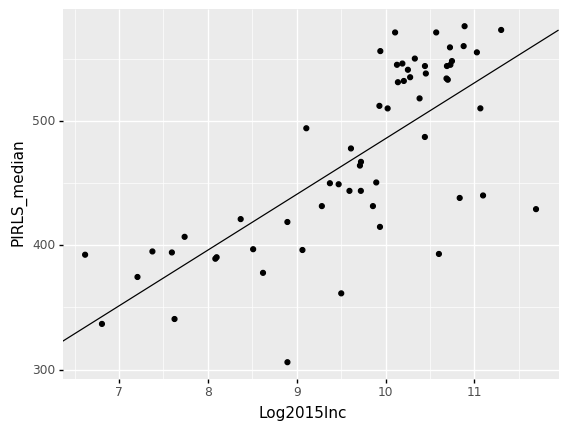

<ggplot: (8790363854617)>

In [121]:
ggplot(data=countInc)+\
    geom_point(mapping=aes(x='Log2015Inc', y='PIRLS_median'))+\
    geom_abline(intercept=pirlsModel.params["Intercept"], slope=pirlsModel.params["Log2015Inc"])

Q2: Years of Schooling and Test Scores

The process we follow is similar. We read the files and try to combine the two dataframes.

In [257]:
yosData = pd.read_stata('./Project 2/rosetta/BL2013_MF1599_v2.2.dta')
print(yosData.shape)
yosData.head(15)

(1898, 20)


,BLcode,country,year,sex,agefrom,ageto,lu,lp,lpc,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,WBcode,region_code
0,1.0,Algeria,1950.0,MF,15.0,999.0,80.684593,17.563400,3.745905,1.454129,0.459588,0.297876,0.164790,0.846457,0.744399,0.092804,0.009253,5241.0,DZA,Middle East and North Africa
1,1.0,Algeria,1955.0,MF,15.0,999.0,81.050957,17.018442,3.464397,1.639253,0.495228,0.259414,0.141776,0.835015,0.728405,0.098586,0.008024,5699.0,DZA,Middle East and North Africa
2,1.0,Algeria,1960.0,MF,15.0,999.0,82.611153,14.313748,3.069391,2.752519,1.049408,0.322578,0.173414,0.880083,0.706000,0.164163,0.009920,6073.0,DZA,Middle East and North Africa
3,1.0,Algeria,1965.0,MF,15.0,999.0,80.931877,14.420929,4.006678,4.209821,1.791863,0.426420,0.226569,1.096061,0.831003,0.251998,0.013060,6374.0,DZA,Middle East and North Africa
4,1.0,Algeria,1970.0,MF,15.0,999.0,73.636833,19.217760,5.225636,6.686831,3.256895,0.344648,0.179372,1.554976,1.155191,0.389305,0.010480,7100.0,DZA,Middle East and North Africa
5,1.0,Algeria,1975.0,MF,15.0,999.0,64.445854,25.242773,4.261852,9.573393,5.095520,0.737983,0.375327,2.113548,1.503821,0.587460,0.022266,8392.0,DZA,Middle East and North Africa
6,1.0,Algeria,1980.0,MF,15.0,999.0,55.763638,29.513348,4.594354,13.199361,7.560233,1.523653,0.767271,2.813867,1.906612,0.861437,0.045818,10188.0,DZA,Middle East and North Africa
7,1.0,Algeria,1985.0,MF,15.0,999.0,45.778404,33.124439,13.015716,18.556147,11.307579,2.541010,1.335532,3.986909,2.650034,1.259344,0.077531,12172.0,DZA,Middle East and North Africa
8,1.0,Algeria,1990.0,MF,15.0,999.0,38.879478,35.206356,14.738846,22.214684,14.352455,3.699486,1.966124,4.744643,3.053206,1.578125,0.113312,14404.0,DZA,Middle East and North Africa
9,1.0,Algeria,1995.0,MF,15.0,999.0,32.885612,37.970692,19.335825,24.434116,16.373421,4.709579,2.527961,5.410806,3.467817,1.798238,0.144751,17068.0,DZA,Middle East and North Africa


It makes sense here to get only the 2010 related rows for each country, and keep only the relative data

In [123]:
yosData["year"].max()

2010.0

In [124]:
yosDataFiltered = yosData.copy()
yosDataFiltered =yosDataFiltered.loc[yosDataFiltered["year"]==2010]
print(yosDataFiltered.shape)
yosDataFiltered.sample(5)

(146, 20)


,BLcode,country,year,sex,agefrom,ageto,lu,lp,lpc,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,WBcode,region_code
1169,109.0,Cyprus,2010.0,MF,15.0,999.0,0.735257,20.662457,15.527176,49.781475,35.053616,28.820812,20.754393,11.067632,5.801826,4.274302,0.991504,725.0,CYP,Middle East and North Africa
1624,156.0,Albania,2010.0,MF,15.0,999.0,3.275412,9.357526,9.031752,85.780670,42.903282,1.586393,0.926950,9.927752,6.475314,3.402170,0.050267,2431.0,ALB,Europe and Central Asia
324,36.0,Sierra Leone,2010.0,MF,15.0,999.0,56.996639,15.556563,7.868874,25.284058,7.663700,2.162898,1.224184,4.226368,2.670773,1.487854,0.067742,3493.0,SLE,Sub-Saharan Africa
467,49.0,Barbados,2010.0,MF,15.0,999.0,0.219284,9.404102,4.058902,85.747711,21.764475,4.628910,2.074464,9.447271,5.826487,3.486716,0.134068,225.0,BRB,Latin America and the Caribbean
1221,114.0,Greece,2010.0,MF,15.0,999.0,2.512367,31.054466,27.645727,41.679939,29.046425,24.753227,22.500219,10.299049,5.746996,3.606985,0.945069,9649.0,GRC,Advanced Economies


In [258]:
yosDataFiltered.rename(columns = {'WBcode': 'Country Code'}, inplace=True)
print(yosDataFiltered.shape)
yosDataFiltered.sample(5)

(146, 20)


,BLcode,country,year,sex,agefrom,ageto,lu,lp,lpc,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,Country Code,region_code
727,73.0,Guyana,2010.0,MF,15.0,999.0,4.785730,34.970890,20.254313,59.830585,33.007721,0.412793,0.240648,8.789074,5.271359,3.504647,0.013068,545.0,GUY,Latin America and the Caribbean
428,45.0,Democratic Republic of the Congo,2010.0,MF,15.0,999.0,44.336948,31.424526,7.169810,23.365906,12.562407,0.880093,0.461686,3.662045,2.612590,1.022620,0.026835,35083.0,COD,Sub-Saharan Africa
285,31.0,Niger,2010.0,MF,15.0,999.0,72.854950,19.877380,13.117042,6.298571,3.385091,0.969099,0.507727,1.876762,1.425893,0.421333,0.029537,8403.0,NER,Sub-Saharan Africa
1676,310.0,Cambodia,2010.0,MF,15.0,999.0,22.222612,57.879772,24.850319,17.479650,4.513436,2.417965,1.315752,4.720442,3.675760,0.970008,0.074674,10114.0,KHM,East Asia and the Pacific
272,30.0,Mozambique,2010.0,MF,15.0,999.0,68.141121,24.231895,16.467070,7.163642,3.381902,0.463339,0.260846,1.926388,1.579990,0.331914,0.014484,12336.0,MOZ,Sub-Saharan Africa


In [259]:
missingValues = list( set(countInc["Country Code"]) - set(yosDataFiltered["Country Code"]))
print(missingValues) 

['TCD', 'AZE', 'BFA', 'GEO', 'OMN']


We notice missing values, so let's merge with right join

In [260]:
yosAndIncome = pd.merge(countInc, yosDataFiltered[['Country Code', 'yr_sch','yr_sch_pri','yr_sch_sec', 'yr_sch_ter']], on='Country Code', how='left')
print(yosAndIncome.shape)
yosAndIncome.head(5)

(59, 12)


,Country,Country Code,TIMSS_prc,PIRLS_prc,TIMMS_median,PIRLS_median,2015Inc,Log2015Inc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter
0,U.A.E.,ARE,64.000000,63.982311,437.000000,440.000000,65975.375547,11.097037,9.066772,5.076396,3.531861,0.458515
1,Argentina,ARG,51.000000,66.000000,406.652557,431.443542,19101.297392,9.857512,9.510379,6.565071,2.664423,0.280885
2,Australia,AUS,90.000000,92.932800,520.000000,534.000000,43719.502165,10.685550,11.541207,5.966004,4.585290,0.989913
3,Austria,AUT,95.302193,97.104111,511.000000,533.000000,44353.875214,10.699955,9.603404,3.848745,5.260084,0.494575
4,Azerbaijan,AZE,72.284508,81.859566,465.000000,467.000000,16698.863653,9.723096,NaN,NaN,NaN,NaN


Sort DF by country code to make sure we have the residuals correctly put

In [261]:
yosAndIncome = yosAndIncome.sort_values(by="Country Code")
yosAndIncome["yr_sch"] = yosAndIncome["yr_sch"].fillna(yosAndIncome["yr_sch"].mean())

In [262]:
yosModel = smf.ols('yr_sch ~ Log2015Inc', data=yosAndIncome).fit()
yosModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yr_sch   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     94.66
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           1.02e-13
Time:                        18:57:22   Log-Likelihood:                -112.01
No. Observations:                  59   AIC:                             228.0
Df Residuals:                      57   BIC:                             232.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.0832      1.766     -4.576      0.000     -11.620      -4.546
Log2015Inc     1.7603      0.181      9.729      0.000       1.398       2.123
==============================================================================
Omnibus:                        0.450   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.799   Jarque-Bera (JB):                0.080
Skew:                           0.048   Prob(JB):                        0.961
Kurtosis:                       3.153   Cond. No.                         81.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Data is sorted by country names so we will have no problem when combining the produced residuals

In [263]:
timsSchlRes = pd.DataFrame(list(zip(timmsModel.resid, yosModel.resid)), columns=["TIMMS_score_res", "Years_of_Schooling_res"])
print(timsSchlRes.shape)
timsSchlRes.sample(5)

(59, 2)


,TIMMS_score_res,Years_of_Schooling_res
11,-12.719101,-0.017058
44,62.290246,-2.329806
22,27.603144,1.026280
53,41.789345,1.884727
3,18.819653,-1.148006


In [264]:
pirlsSchlRes = pd.DataFrame(list(zip(pirlsModel.resid, yosModel.resid)), columns=["PIRLS_score_res", "Years_of_Schooling_res"])
print(pirlsSchlRes.shape)
pirlsSchlRes.sample(5)

(59, 2)


,PIRLS_score_res,Years_of_Schooling_res
35,-5.892353,-2.022881
34,-18.499241,0.220822
36,-22.109538,-0.289507
28,23.275847,0.699576
21,59.779160,-0.685464


In [265]:
timsSchlModel = smf.ols('TIMMS_score_res ~ Years_of_Schooling_res', data=timsSchlRes).fit()
print(timsSchlModel.summary())

                            OLS Regression Results                            
Dep. Variable:        TIMMS_score_res   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     16.29
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           0.000164
Time:                        18:57:41   Log-Likelihood:                -316.63
No. Observations:                  59   AIC:                             637.3
Df Residuals:                      57   BIC:                             641.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.75

In [266]:
pirlsSchlModel = smf.ols('PIRLS_score_res ~ Years_of_Schooling_res', data=pirlsSchlRes).fit()
print(pirlsSchlModel.summary())

                            OLS Regression Results                            
Dep. Variable:        PIRLS_score_res   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     25.38
Date:                Sat, 03 Apr 2021   Prob (F-statistic):           5.06e-06
Time:                        18:57:48   Log-Likelihood:                -303.03
No. Observations:                  59   AIC:                             610.1
Df Residuals:                      57   BIC:                             614.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                2.8

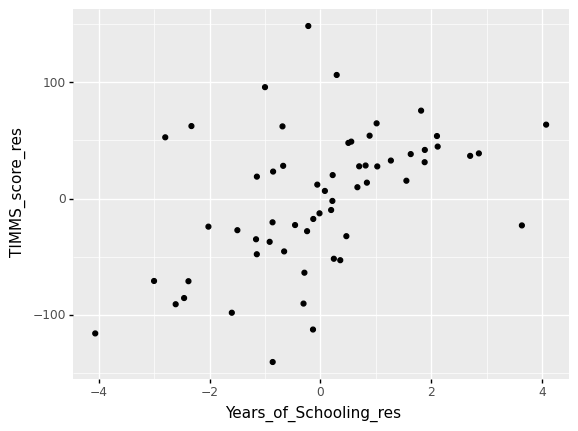

<ggplot: (8790364299865)>

In [137]:
ggplot(data=timsSchlRes)+\
    geom_point(mapping=aes(x='Years_of_Schooling_res', y='TIMMS_score_res'))

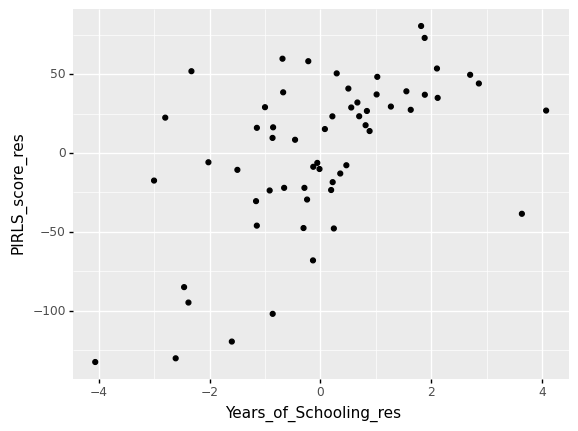

<ggplot: (8790364376461)>

In [138]:
ggplot(data=pirlsSchlRes)+\
    geom_point(mapping=aes(x='Years_of_Schooling_res', y='PIRLS_score_res'))

Note to professor: I can see here I was a bit off with my plots. I've included a few more data points. Would be great to review together in a call after the exams are done

Q3: Compare New and Previous Estimates

Again, we simply follow the instructions of the assignment reading and combining the data

In [267]:
hloData = pd.read_stata('./Project 2/rosetta/HLO Panel Data (mean, thresh) - Jan 2018.dta')
print(hloData.shape)
hloData.head(15)

(1849, 6)


,country,idcntry,cntabb,year,HLO,low_threshold
0,"Abu Dhabi, UAE",7842,ADA,1965,NaN,NaN
1,"Abu Dhabi, UAE",7842,ADA,1970,NaN,NaN
2,"Abu Dhabi, UAE",7842,ADA,1975,NaN,NaN
3,"Abu Dhabi, UAE",7842,ADA,1980,NaN,NaN
4,"Abu Dhabi, UAE",7842,ADA,1985,NaN,NaN
5,"Abu Dhabi, UAE",7842,ADA,1990,NaN,NaN
6,"Abu Dhabi, UAE",7842,ADA,1995,NaN,NaN
7,"Abu Dhabi, UAE",7842,ADA,2000,NaN,NaN
8,"Abu Dhabi, UAE",7842,ADA,2005,NaN,NaN
9,"Abu Dhabi, UAE",7842,ADA,2010,428.679993,73.830002


In [268]:
hloData["year"].max()

2015

After we make sure our latest year is 2015 we want to fill the NA values accordingly, by pushing the previous valid value to the rest of the rows. Then we can filter and get the latest year, which is what we want

In [141]:
hloDataFiltered = hloData.copy()
hloDataFiltered = hloDataFiltered.fillna(method='ffill')
hloDataFiltered =hloDataFiltered.loc[hloDataFiltered["year"]==2015]
print(hloDataFiltered.shape)
hloDataFiltered.sample(5)

(169, 6)


,country,idcntry,cntabb,year,HLO,low_threshold
241,Burkina Faso,854,BFA,2015,296.880005,37.139999
1153,Montenegro,499,MNE,2015,441.380005,71.419998
922,Lebanon,422,LBN,2015,454.420013,79.879997
1109,"Mexico, Nuevo Leo",4841,NMX,2015,472.380005,81.199997
1065,"Massachusetts, USA",9143,QUC,2015,522.619995,91.180000


In [269]:
hloDataFiltered.rename(columns = {'cntabb': 'Country Code'}, inplace=True)

In [270]:
incAndHlo = pd.merge(countInc, hloDataFiltered[['Country Code', 'low_threshold']], on='Country Code', how='left')
print(incAndHlo.shape)
incAndHlo.sample(5)

(59, 9)


,Country,Country Code,TIMSS_prc,PIRLS_prc,TIMMS_median,PIRLS_median,2015Inc,Log2015Inc,low_threshold
54,Sweden,SWE,93.0,97.592010,507.000000,545.000000,45679.277997,10.729400,92.769997
16,Germany,DEU,97.0,97.610596,530.000000,544.000000,43937.947132,10.690534,91.690002
58,United States,USA,96.0,97.517357,544.000000,560.000000,53029.293361,10.878600,93.300003
18,Dominican Republic,DOM,12.0,33.000000,303.594055,361.333984,13371.524988,9.500883,43.099998
11,Cameroon,CMR,41.0,46.000000,375.240479,390.343994,3289.064546,8.098358,44.500000


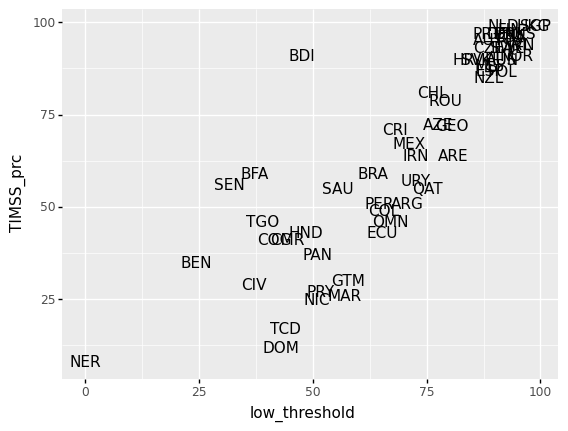

<ggplot: (8790035802117)>

In [271]:
ggplot(data=incAndHlo)+\
    geom_text(aes(x='low_threshold', y='TIMSS_prc',label='Country Code'))


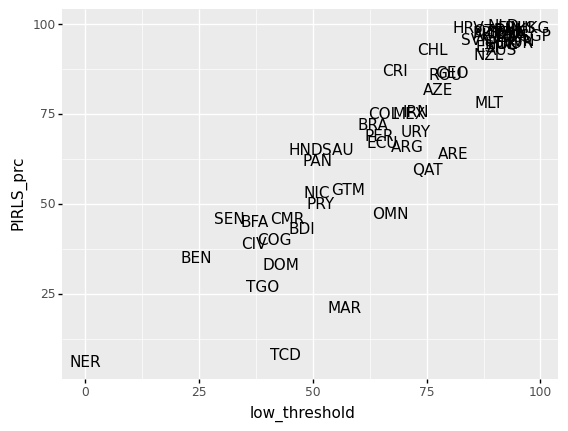

<ggplot: (8790364810169)>

In [150]:
ggplot(data=incAndHlo)+\
    geom_text(aes(x='low_threshold', y='PIRLS_prc',label='Country Code'))


Q4: Skills Intensity

In [151]:
cwIndData = pd.read_stata('./Project 2/rosetta/cw_ind2000_ind1990ddx.dta')
print(cwIndData.shape)
cwIndData.sample(5)

(712, 3)


,ind2000,ind1990ddx,weight
300,398,242,0.008365
660,888,771,0.051591
572,788,780,0.018478
106,179,220,0.233726
66,128,110,0.005503


In [152]:
cwHs6Data = pd.read_stata('./Project 2/rosetta/cw_hs6_sic87dd.dta')
print(cwHs6Data.shape)
cwHs6Data.sample(5)

(6752, 4)


,hs6,sic87dd,share,weights_method
2835,520859.0,2211.0,1.000000,no weights needed
4570,741533.0,3452.0,1.000000,no weights needed
373,80410.0,2034.0,0.146468,trade-based
45,20410.0,2011.0,1.000000,no weights needed
2287,410121.0,2011.0,1.000000,no weights needed


In [153]:
cwSicData = pd.read_stata('./Project 2/rosetta/cw_sic87_ind1990ddx.dta')
print(cwSicData.shape)
cwSicData.sample(5)

(1004, 2)


,ind1990ddx,sic87
687,550,5142
772,682,5995
392,272,3369
144,112,2067
539,371,3812


In [249]:
cwIndData.head(5)

,ind2000,ind1990ddx,weight
0,17,10,0.994016
1,17,31,0.002637
2,17,121,0.001740
3,17,561,0.001607
4,18,11,0.990907


Make it easier to work with by assigning a letter for the education level. So we can group easier. The instructions are clearing the steps we need to take. I was initially thinking (before reading that the weight for the two years was included), to hold the sum in grouping and use that for later calculation.<br>
This next function assigns correctly the level of education based on years

In [155]:
def skillSet(row):
    if(row["EDUC"]>=10):
        return "C"
    elif(row["EDUC"]>=6):
        return "H"
    else:
        return "O"

In [156]:
usData = census.copy()
usData["EDULVL"] = usData.apply(skillSet, axis=1)
usData.sample(5)

,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND,EDULVL
222816,2000,200004,94451,1800.0,2000000944514,36,1,3,1664.0,1,10,0,0,9920,0,O
282331,2000,200004,119887,600.0,2000001198874,9,1,2,618.0,10,101,3,30,9920,0,C
315423,2000,200004,133962,500.0,2000001339624,5,1,6,488.0,0,1,0,0,9920,0,O
2540,2000,200004,1056,500.0,2000000010564,5,1,1,486.0,6,62,3,30,9920,0,H
292505,2000,200004,124162,2100.0,2000001241624,26,1,2,2161.0,1,10,0,0,9920,0,O


Next we would like to group based on the industry and education level. This will need some processing of the result, to form it to a proper dataset

In [170]:
usDataGrouped = usData.groupby(by=["IND","EDULVL"])[["PERWT"]].sum()
usDataGrouped.head(5)

PERWT
IND EDULVL            
0   C        5117532.0
    H       23197023.0
    O       80057089.0
17  C         133389.0
    H         673515.0

In [171]:
usDataGrouped = usDataGrouped["PERWT"].reset_index()
usDataGrouped.head(5)

,IND,EDULVL,PERWT
0,0,C,5117532.0
1,0,H,23197023.0
2,0,O,80057089.0
3,17,C,133389.0
4,17,H,673515.0


In [176]:
usDataGrouped = usDataGrouped.pivot(index="IND", columns="EDULVL")["PERWT"].reset_index()
usDataGrouped.columns.name=None
usDataGrouped.head(5)

,IND,C,H,O
0,0,5117532.0,23197023.0,80057089.0
1,17,133389.0,673515.0,584611.0
2,18,70935.0,445599.0,206550.0
3,19,10095.0,19550.0,2435.0
4,27,7917.0,105065.0,34338.0


Now that the dataframe is more understandable and easy to work with, we can calculate the Averages

In [179]:
usDataGrouped["C_AVG"] = usDataGrouped["C"] / (usDataGrouped["C"]+usDataGrouped["H"]+usDataGrouped["O"])
usDataGrouped["H_AVG"] = usDataGrouped["H"] / (usDataGrouped["C"]+usDataGrouped["H"]+usDataGrouped["O"])
usDataGrouped.head(5)

,IND,C,H,O,C_AVG,H_AVG
0,0,5117532.0,23197023.0,80057089.0,0.047222,0.214051
1,17,133389.0,673515.0,584611.0,0.095859,0.484016
2,18,70935.0,445599.0,206550.0,0.098101,0.616248
3,19,10095.0,19550.0,2435.0,0.314682,0.609414
4,27,7917.0,105065.0,34338.0,0.053740,0.713175


In [210]:
print(len(set(cwIndData["ind2000"])))
cwIndData.head(5)

257


,ind2000,ind1990ddx,weight
0,17,10,0.994016
1,17,31,0.002637
2,17,121,0.001740
3,17,561,0.001607
4,18,11,0.990907


In [211]:
len(set(usDataGrouped["IND"]))

266

Let us group the dataframes together based on industry, we would also like to remove the extra Industry column

In [242]:
siiData = pd.merge(cwIndData, usDataGrouped[['IND', 'C_AVG', 'C', 'H_AVG', 'H']], left_on='ind2000',right_on='IND', how='inner')
print(siiData.shape)
siiData.head(5)

(712, 8)


,ind2000,ind1990ddx,weight,IND,C_AVG,C,H_AVG,H
0,17,10,0.994016,17,0.095859,133389.0,0.484016,673515.0
1,17,31,0.002637,17,0.095859,133389.0,0.484016,673515.0
2,17,121,0.001740,17,0.095859,133389.0,0.484016,673515.0
3,17,561,0.001607,17,0.095859,133389.0,0.484016,673515.0
4,18,11,0.990907,18,0.098101,70935.0,0.616248,445599.0


In [243]:
siiData = siiData.drop('IND', axis=1)
siiData.head(5)

,ind2000,ind1990ddx,weight,C_AVG,C,H_AVG,H
0,17,10,0.994016,0.095859,133389.0,0.484016,673515.0
1,17,31,0.002637,0.095859,133389.0,0.484016,673515.0
2,17,121,0.001740,0.095859,133389.0,0.484016,673515.0
3,17,561,0.001607,0.095859,133389.0,0.484016,673515.0
4,18,11,0.990907,0.098101,70935.0,0.616248,445599.0


In [244]:
siiData["N_CAVG"] = siiData["C_AVG"] * siiData["weight"]
siiData["N_HAVG"] = siiData["H_AVG"] * siiData["weight"]
siiData.head(5)

,ind2000,ind1990ddx,weight,C_AVG,C,H_AVG,H,N_CAVG,N_HAVG
0,17,10,0.994016,0.095859,133389.0,0.484016,673515.0,0.095285,0.481119
1,17,31,0.002637,0.095859,133389.0,0.484016,673515.0,0.000253,0.001276
2,17,121,0.001740,0.095859,133389.0,0.484016,673515.0,0.000167,0.000842
3,17,561,0.001607,0.095859,133389.0,0.484016,673515.0,0.000154,0.000778
4,18,11,0.990907,0.098101,70935.0,0.616248,445599.0,0.097209,0.610644


In [223]:
baci.head(5)

,t,i,j,k,v,q
0,2018,4,24,845420,101.397000,26.000
1,2018,4,24,848180,2.328000,0.007
2,2018,4,31,570110,1.596000,0.037
3,2018,4,32,340319,8.699331,0.113
4,2018,4,32,610910,1.098000,0.013


Next we follow the instructions given to us to merge and finalise the dataframe

In [225]:
cwHs6Data.loc[ cwHs6Data["hs6"]== 845420]

,hs6,sic87dd,share,weights_method
5308,845420.0,3321.0,0.636426,trade-based
5309,845420.0,3559.0,0.363574,trade-based


In [226]:
baciHs6Data = pd.merge(baci, cwHs6Data[['hs6', 'sic87dd', 'share']], left_on='k',right_on='hs6', how='inner')
print(baciHs6Data.shape)
baciHs6Data.head(5)

(9631896, 9)


,t,i,j,k,v,q,hs6,sic87dd,share
0,2018,4,24,845420,101.397000,26.000,845420.0,3321.0,0.636426
1,2018,4,24,845420,101.397000,26.000,845420.0,3559.0,0.363574
2,2018,36,288,845420,16.384946,0.177,845420.0,3321.0,0.636426
3,2018,36,288,845420,16.384946,0.177,845420.0,3559.0,0.363574
4,2018,36,360,845420,7.109000,0.017,845420.0,3321.0,0.636426


In [228]:
baciHs6Data["T_AMOUNT"] = baciHs6Data["v"] * baciHs6Data["share"]
baciHs6Data.head(5)

,t,i,j,k,v,q,hs6,sic87dd,share,T_AMOUNT
0,2018,4,24,845420,101.397000,26.000,845420.0,3321.0,0.636426,64.531708
1,2018,4,24,845420,101.397000,26.000,845420.0,3559.0,0.363574,36.865292
2,2018,36,288,845420,16.384946,0.177,845420.0,3321.0,0.636426,10.427809
3,2018,36,288,845420,16.384946,0.177,845420.0,3559.0,0.363574,5.957137
4,2018,36,360,845420,7.109000,0.017,845420.0,3321.0,0.636426,4.524354


In [232]:
baciHs6DataGrouped = baciHs6Data.groupby(by=["i","sic87dd"])[["T_AMOUNT"]].sum()
baciHs6DataGrouped.head(5)

T_AMOUNT
i sic87dd              
4 119.0    68290.428330
  131.0    39698.892614
  132.0       43.993665
  134.0      380.462682
  139.0    13308.065785

In [234]:
baciHs6DataGrouped = baciHs6DataGrouped["T_AMOUNT"].reset_index()
baciHs6DataGrouped.head(5)

,i,sic87dd,T_AMOUNT
0,4,119.0,68290.428330
1,4,131.0,39698.892614
2,4,132.0,43.993665
3,4,134.0,380.462682
4,4,139.0,13308.065785


In [219]:
cwSicData.head(5)

,ind1990ddx,sic87
0,10,111
1,10,112
2,10,115
3,10,116
4,10,119


In [235]:
cwSicBaciHs6Data = pd.merge(cwSicData, baciHs6DataGrouped, left_on='sic87',right_on='sic87dd', how='inner')
print(cwSicBaciHs6Data.shape)
cwSicBaciHs6Data.head(5)

(67052, 5)


,ind1990ddx,sic87,i,sic87dd,T_AMOUNT
0,10,112,31,112.0,8.024000
1,10,112,32,112.0,1348.391771
2,10,112,36,112.0,466.484000
3,10,112,40,112.0,149.945440
4,10,112,48,112.0,87.404000


In [236]:
countryCodes.head(5)

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND


In [237]:
cwSicBaciHs6Data = pd.merge(cwSicBaciHs6Data, countryCodes[['country_code','iso_3digit_alpha']], left_on='i',right_on='country_code', how='inner')
print(cwSicBaciHs6Data.shape)
cwSicBaciHs6Data.head(5)

(67052, 7)


,ind1990ddx,sic87,i,sic87dd,T_AMOUNT,country_code,iso_3digit_alpha
0,10,112,31,112.0,8.024000,31,AZE
1,10,115,31,115.0,52.160484,31,AZE
2,10,119,31,119.0,2312.346783,31,AZE
3,10,131,31,131.0,80377.093494,31,AZE
4,10,132,31,132.0,12685.514992,31,AZE


In [238]:
cwSicBaciHs6Data = cwSicBaciHs6Data.drop("i", axis=1)
cwSicBaciHs6Data.head(5)

,ind1990ddx,sic87,sic87dd,T_AMOUNT,country_code,iso_3digit_alpha
0,10,112,112.0,8.024000,31,AZE
1,10,115,115.0,52.160484,31,AZE
2,10,119,119.0,2312.346783,31,AZE
3,10,131,131.0,80377.093494,31,AZE
4,10,132,132.0,12685.514992,31,AZE


In [250]:
siiData.loc[siiData["ind1990ddx"]==10]

,ind2000,ind1990ddx,weight,C_AVG,C,H_AVG,H,N_CAVG,N_HAVG
0,17,10,0.994016,0.095859,133389.0,0.484016,673515.0,0.095285,0.481119
10,29,10,0.349020,0.158365,31875.0,0.515355,103728.0,0.055273,0.179869


In [253]:
complete = pd.merge(cwSicBaciHs6Data, siiData[["ind2000","ind1990ddx", "N_CAVG", "N_HAVG"]], on="ind1990ddx", how='inner')
print(complete.shape)
complete.head(5)

(317376, 9)


,ind1990ddx,sic87,sic87dd,T_AMOUNT,country_code,iso_3digit_alpha,ind2000,N_CAVG,N_HAVG
0,10,112,112.0,8.024000,31,AZE,17,0.095285,0.481119
1,10,112,112.0,8.024000,31,AZE,29,0.055273,0.179869
2,10,115,115.0,52.160484,31,AZE,17,0.095285,0.481119
3,10,115,115.0,52.160484,31,AZE,29,0.055273,0.179869
4,10,119,119.0,2312.346783,31,AZE,17,0.095285,0.481119


Note to professor: At this point I can see that there are duplicate values since some 90s industries were listed in two different in the 2000s. I would also like to review this point with you, and see the mistake I made. I would assume I simply kept or calculated something wrong in a merge. Or I understood the question wrong. Happy to discuss and improve.

In [247]:
country_scores.head(5)

,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,U.A.E.,ARE,64.000000,63.982311,437.000000,440.000000
1,Argentina,ARG,51.000000,66.000000,406.652557,431.443542
2,Armenia,ARM,71.505402,NaN,454.000000,NaN
3,Australia,AUS,90.000000,92.932800,520.000000,534.000000
4,Austria,AUT,95.302193,97.104111,511.000000,533.000000


In [273]:
finalData = pd.merge(country_scores, complete, left_on='Country Code',right_on='iso_3digit_alpha', how='inner')
print(finalData.shape)
finalData.head(5)

(141210, 15)


,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)",ind1990ddx,sic87,sic87dd,T_AMOUNT,country_code,iso_3digit_alpha,ind2000,N_CAVG,N_HAVG
0,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,112,112.0,983.909632,784,ARE,17,0.095285,0.481119
1,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,112,112.0,983.909632,784,ARE,29,0.055273,0.179869
2,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,115,115.0,25190.509539,784,ARE,17,0.095285,0.481119
3,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,115,115.0,25190.509539,784,ARE,29,0.055273,0.179869
4,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,119,119.0,250766.719218,784,ARE,17,0.095285,0.481119


In [274]:
finalData.drop(["sic87dd", "country_code", "iso_3digit_alpha"], inplace=True, axis=1)

In [275]:
finalData.head(5)

,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)",ind1990ddx,sic87,T_AMOUNT,ind2000,N_CAVG,N_HAVG
0,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,112,983.909632,17,0.095285,0.481119
1,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,112,983.909632,29,0.055273,0.179869
2,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,115,25190.509539,17,0.095285,0.481119
3,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,115,25190.509539,29,0.055273,0.179869
4,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,119,250766.719218,17,0.095285,0.481119


In [276]:
finalData.rename(columns = {'Median Math Score (TIMSS Scale, 4th Grade)': 'Median_Timms', 'Median Reading Score (PIRLS Scale, 4th Grade)': "Median_Pirls","Country Code": "Country_Code"}, inplace=True)

In [282]:
finalData.head(2)

,Country,Country_Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),Median_Timms,Median_Pirls,ind1990ddx,sic87,T_AMOUNT,ind2000,N_CAVG,N_HAVG,Th_Timms,Th_Pirls
0,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,112,983.909632,17,0.095285,0.481119,0.437,0.44
1,U.A.E.,ARE,64.0,63.982311,437.0,440.0,10,112,983.909632,29,0.055273,0.179869,0.437,0.44


In [287]:
finalData["Th_Timms"] = finalData["Median_Timms"] / 1000
finalData["Th_Pirls"] = finalData["Median_Pirls"] / 1000
finalData["LogValue"] = np.log(finalData["T_AMOUNT"])

Finally we create and summarise our models and get similar results. 

In [290]:
valueTimmsCollege = smf.ols('LogValue ~ Th_Timms:N_CAVG + ind2000 + Country_Code', data=finalData).fit()
print(valueTimmsCollege.summary())

                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2516.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:30:28   Log-Likelihood:            -2.9570e+05
No. Observations:              127779   AIC:                         5.915e+05
Df Residuals:                  127707   BIC:                         5.922e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.7547    

In [291]:
valuePirlsCollege = smf.ols('LogValue ~ Th_Pirls:N_CAVG + ind2000 + Country_Code', data=finalData).fit()
print(valueTimmsCollege.summary())

                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2516.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:30:32   Log-Likelihood:            -2.9570e+05
No. Observations:              127779   AIC:                         5.915e+05
Df Residuals:                  127707   BIC:                         5.922e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.7547    

In [292]:
valueTimmsHigh = smf.ols('LogValue ~ Th_Timms:N_HAVG + ind2000 + Country_Code', data=finalData).fit()
print(valueTimmsCollege.summary())

                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2516.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:30:38   Log-Likelihood:            -2.9570e+05
No. Observations:              127779   AIC:                         5.915e+05
Df Residuals:                  127707   BIC:                         5.922e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.7547    

In [293]:
valuePirlsHigh = smf.ols('LogValue ~ Th_Pirls:N_HAVG + ind2000 + Country_Code', data=finalData).fit()
print(valueTimmsCollege.summary())

                            OLS Regression Results                            
Dep. Variable:               LogValue   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2516.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:30:41   Log-Likelihood:            -2.9570e+05
No. Observations:              127779   AIC:                         5.915e+05
Df Residuals:                  127707   BIC:                         5.922e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.7547    

Final Note: I'd like to say once more, I enjoy this kind of assignments, so I'd like to get better at it. So happy to discuss it once you get the results public :) 